## Using text in AI systems

### Text processing
* Cleaning
    * get rid of garbage 
    * handle punctuation
    * lower the text
    * stemming / lemming
    * get rid of stopwords
* Choices
    * use letters
    * use words
    * sequence delimiter
* Building a vocabulary

### The ML part
* Embedding text to numbers
    * making a vocab
    * different tehniques (CBOW/SkipGram)
    * vectorizing the text
* Arhitecture choices
    * RNN vs CNN
    * LSTM vs GRU

### Cleaning text

In [3]:
import string
import re
import nltk
import json
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [4]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yourlogarithm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
sample = 'ANA are3 mere!!! ! !  GAMING Dar ioana.....? ┤ÑI▄ë. the the the the banking'

In [6]:
# Garbage (here we clean non-printable characters)
# sample = ''.join(filter(lambda x: x in string.printable, sample))
sample = ''.join([el for el in sample if el in string.printable])
print(sample)

ANA are3 mere!!! ! !  GAMING Dar ioana.....? I. the the the the banking


In [7]:
#Spacing (here we space out punctuation / numbers)
sample = re.sub('([.,#!?()0-9])', r' \1 ', sample)
print(sample)

ANA are 3  mere !  !  !   !   !   GAMING Dar ioana .  .  .  .  .  ?  I .  the the the the banking


In [8]:
sample = re.sub('\s{2,}', ' ', sample)
print(sample)

ANA are 3 mere ! ! ! ! ! GAMING Dar ioana . . . . . ? I . the the the the banking


In [9]:
#Text lowering
sample = sample.lower()
print(sample)

ana are 3 mere ! ! ! ! ! gaming dar ioana . . . . . ? i . the the the the banking


In [10]:
#Stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer()

print(ps.stem('banking'))

bank


In [11]:
sample = ' '.join([ps.stem(word) for word in sample.split()])
print(sample)

ana are 3 mere ! ! ! ! ! game dar ioana . . . . . ? i . the the the the bank


In [12]:
#removing stopwords
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
print(eng_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
eng_stopwords = set(eng_stopwords)
sample = ' '.join([word for word in sample.split() if word not in eng_stopwords])
print(sample)

ana 3 mere ! ! ! ! ! game dar ioana . . . . . ? . bank


In [14]:
#Vocab building
with open('dset.json') as f:
    dataset = json.load(open('dset.json'))
dataset[:3]

[{'ItemID': '1',
  'Sentiment': '0',
  'SentimentText': 'is so sad for my APL friend.............'},
 {'ItemID': '2',
  'Sentiment': '0',
  'SentimentText': 'I missed the New Moon trailer...'},
 {'ItemID': '3', 'Sentiment': '1', 'SentimentText': 'omg its already 7:30 :O'}]

In [15]:
def process_seq(sample):
    sample = ''.join(filter(lambda x: x in string.printable, sample))
    sample = re.sub('([.,#!?()0-9])', r' \1 ', sample)
    sample = re.sub('\s{2,}', ' ', sample)
    sample = sample.lower()
    sample = ' '.join([ps.stem(word) for word in sample.split()])
    sample = ' '.join([word for word in sample.split() if word not in eng_stopwords])
    return sample

In [16]:
unparsed_seq = [el['SentimentText'] for el in tqdm(dataset)]
sequences = [process_seq(el['SentimentText']) for el in tqdm(dataset)]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

# Naive Bayes

* https://medium.com/@javiergb_com/why-testing-positive-for-a-disease-may-not-mean-you-are-sick-4a3a16a290eb
* https://scikit-learn.org/stable/modules/naive_bayes.html

## Libraries

In [17]:
import sklearn
print('sklearn version: ' + sklearn.__version__)  # 1.0.2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import pickle
import pandas as pd
pd.options.display.max_colwidth = 120

sklearn version: 1.0.2


## Prepare data

Preprocess a bit more

In [18]:
def process_seq_NB(sample):
    sample = re.sub(r'[ ]*([!@#$%^&*()_\-+=~`\\|\'";:/?.>,<])([ ]*\1[ ]*){2,}', r' \1\1\1 ', sample)  # Collapse >=4 to 3 (punctuation)
    sample = re.sub(r'[ ]*([a-z])([ ]*\1[ ]*){2,}', r'\1\1\1', sample)  # Collapse >=4 to 3 (letters) (same, but no spaces)
    sample = re.sub(r'([.,#!?()0-9])[ ]*\1', r'\1\1', sample)  # Remove spaces between 2 of the same
#     sample = re.sub(r'(\d)\s+(\d)', r'\1\2', sample)  # Remove spaces between 2 digits
    sample = re.sub('\s{2,}', ' ', sample)  # Collapse extra spaces again
    return sample

sequences_NB = [process_seq_NB(s) for s in tqdm(sequences)]
sequences_NB[:10]

  0%|          | 0/100000 [00:00<?, ?it/s]

['sad apl friend ... ',
 'miss new moon trailer ... ',
 'omg alreadi 7 : 3 0 :o',
 ".. omgaga . im soooim gunna cri . i'v thi dentist sinc 11 .. wa supos 2 get crown put ( 3 0 min ) ... ",
 'think mi bf cheat !!! t_t',
 'worri much ?',
 'juuussst chillin !!',
 'sunni work tomorrow :-| tv tonight',
 'hand uniform today . miss alreadi',
 'hmmm... wonder number @- )']

##### Get y, this doesn't go in the vectorizer

In [19]:
y_NB = [int(el['Sentiment']) for el in tqdm(dataset)]

  0%|          | 0/100000 [00:00<?, ?it/s]

Split into train/test dataset

In [20]:
sequences_NB_train, sequences_NB_test, y_NB_train, y_NB_test = train_test_split(sequences_NB, y_NB, test_size=.2, shuffle=False)
len(sequences_NB_train), len(sequences_NB_test), len(y_NB_train), len(y_NB_test)

(80000, 20000, 80000, 20000)

Final version of vectorizer

In [21]:
%%time
vectorizer = CountVectorizer(
    analyzer='word',
    ngram_range=(1, 2), 
    # max_features=100_000, 
    min_df=10, 
)

X_NB_train = vectorizer.fit_transform(sequences_NB_train)
X_NB_test = vectorizer.transform(sequences_NB_test)

features = vectorizer.get_feature_names_out()
print(features.shape, features)

(7004,) ['00' '00 00' '00 follow' ... 'zombi' 'zone' 'zoo']
CPU times: user 776 ms, sys: 26.4 ms, total: 803 ms
Wall time: 805 ms


In [64]:
print(X_NB_train.shape)
print(y_NB_train.shape)

(80000, 7004)


AttributeError: 'list' object has no attribute 'shape'

Train model (MultinomialNB)

In [22]:
model_Multi_NB = MultinomialNB()
model_Multi_NB.fit(X_NB_train, y_NB_train)
print(f'Train score: {model_Multi_NB.score(X_NB_train, y_NB_train): .2%}')
print(f'Test score: {model_Multi_NB.score(X_NB_test, y_NB_test): .2%}')

Train score:  75.02%
Test score:  72.16%


In [23]:
# Save Multinomial model to sidk
with open("model_Multi_NB.dat", 'wb') as fout:
    pickle.dump(model_Multi_NB, fout)
with open("vectorizer_Multi_NB.dat", 'wb') as fout:
    pickle.dump(vectorizer, fout)

<AxesSubplot:>

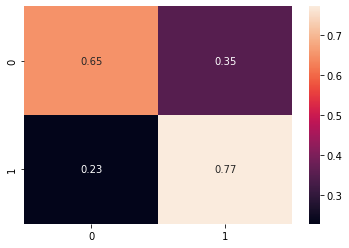

In [24]:
y_NB_pred = model_Multi_NB.predict(X_NB_test)
cmat = metrics.confusion_matrix(y_NB_test, y_NB_pred)
cmn = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True)

## Other trained

#### min_df=1, ngram_range=(1, 2)

In [25]:
%%time
test_vectorizer = CountVectorizer(analyzer='word',
    ngram_range=(1, 2), 
#                              max_features=100_000, 
    min_df=1, 
)
test_X_NB_train, test_X_NB_test = test_vectorizer.fit_transform(sequences_NB_train), test_vectorizer.transform(sequences_NB_test)

test_features = test_vectorizer.get_feature_names_out()
print(test_features.shape, test_features)

(391175,) ['00' '00 00' '00 11' ... 'zzeba harri' 'zzj' 'zzsp']
CPU times: user 1.47 s, sys: 72.1 ms, total: 1.54 s
Wall time: 1.3 s


In [26]:
# MultinomialNB
test_model_Multi_NB = MultinomialNB()
test_model_Multi_NB.fit(test_X_NB_train, y_NB_train)
print(f'Train score: {test_model_Multi_NB.score(test_X_NB_train, y_NB_train): .2%}')
print(f'Test score: {test_model_Multi_NB.score(test_X_NB_test, y_NB_test): .2%}')

Train score:  96.40%
Test score:  72.69%


In [27]:
# Save Multinomial model to disk and vectorizer
t1 = '_Multi_NB_mdf1_ngram12.dat'
with open(f"test_model" + t1, 'wb') as fout:
    pickle.dump(test_model_Multi_NB, fout)
with open(f"test_vectorizer" + t1, 'wb') as fout:
    pickle.dump(test_vectorizer, fout)

#### min_df=1, ngram_range=(1, 6)

In [28]:
%%time
test_vectorizer = CountVectorizer(analyzer='word',
                             ngram_range=(1, 6), 
#                              max_features=100_000, 
                             min_df=1, 
                            )
test_X_NB_train, test_X_NB_test = test_vectorizer.fit_transform(sequences_NB_train), test_vectorizer.transform(sequences_NB_test)

test_features = test_vectorizer.get_feature_names_out()
print(test_features.shape, test_features)

(1492315,) ['00' '00 00' '00 00 00' ... 'zzeba harri potter' 'zzj' 'zzsp']
CPU times: user 4.25 s, sys: 146 ms, total: 4.39 s
Wall time: 4.45 s


In [29]:
# MultinomialNB
test_model_Multi_NB = MultinomialNB()
test_model_Multi_NB.fit(test_X_NB_train, y_NB_train)
print(f'Train score: {test_model_Multi_NB.score(test_X_NB_train, y_NB_train): .2%}')
print(f'Test score: {test_model_Multi_NB.score(test_X_NB_test, y_NB_test): .2%}')

Train score:  98.22%
Test score:  72.70%


In [30]:
# Save Multinomial model to disk and vectorizer
t2 = '_Multi_NB_mdf1_ngram16.dat'
with open(f"test_model" + t2, 'wb') as fout:
    pickle.dump(test_model_Multi_NB, fout)
with open(f"test_vectorizer" + t2, 'wb') as fout:
    pickle.dump(test_vectorizer, fout)

## Speed comparison (min_df=10, ngram_range=(1, 2)) vs (min_df=1, ngram_range=(1, 6))

In [31]:
#OPTIMIZED model
with open("model_Multi_NB.dat", 'rb') as fin:
    test_model_Multi_NB_mdf1_ngram12 = pickle.load(fin)
with open("vectorizer_Multi_NB.dat", 'rb') as fin:
    test_vectorizer_Multi_NB_mdf1_ngram12 = pickle.load(fin)

# BIG model
with open(f"test_model" + t2, 'rb') as fin:
    test_model_Multi_NB_mdf1_ngram16 = pickle.load(fin)
with open(f"test_vectorizer" + t2, 'rb') as fin:
    test_vectorizer_Multi_NB_mdf1_ngram16 = pickle.load(fin)

In [32]:
%%time
X_NB = test_vectorizer_Multi_NB_mdf1_ngram12.transform(sequences_NB);

CPU times: user 572 ms, sys: 5.25 ms, total: 578 ms
Wall time: 577 ms


In [33]:
%%time
test_model_Multi_NB_mdf1_ngram12.score(X_NB, y_NB)

CPU times: user 19.6 ms, sys: 1.83 ms, total: 21.5 ms
Wall time: 20.5 ms


0.74448

In [34]:
%%time
X_NB = test_vectorizer_Multi_NB_mdf1_ngram16.transform(sequences_NB);

CPU times: user 1.48 s, sys: 17.7 ms, total: 1.5 s
Wall time: 1.5 s


In [35]:
%%time
test_model_Multi_NB_mdf1_ngram16.score(X_NB, y_NB)

CPU times: user 40 ms, sys: 13.1 ms, total: 53.1 ms
Wall time: 69.1 ms


0.93116

## Some examples

In [36]:
sequences_NB[0]

'sad apl friend ... '

In [37]:
row0 = X_NB_train[0]
row0.data, row0.indices

(array([1, 1]), array([5132, 2294], dtype=int32))

In [38]:
features[row0.indices]

array(['sad', 'friend'], dtype=object)

Sparse matrices are a bit weird, but what this tells us is that the first phrase is represented as a vector with 1s in two positions which correspond to the ngrams "sad" and "friend".

In [39]:
b = model_Multi_NB.class_log_prior_ # Likelihoods of classes before looking at the phrase
w = model_Multi_NB.feature_log_prob_.T # Values with which likelihood is adjusted given the presence of our selected N-grams

b, w

(array([-0.81587995, -0.58384445]),
 array([[ -6.23451184,  -5.99711349],
        [ -9.76988143, -10.11096355],
        [-10.72539288,  -7.5252522 ],
        ...,
        [ -9.69577346, -10.31163425],
        [ -9.76988143,  -9.86980149],
        [-10.25538925,  -9.56441985]]))

In [40]:
w[row0.indices]

array([[-5.40825376, -8.34997574],
       [-6.41325237, -6.41981395]])

In [41]:
out = b + (row0.data * w[row0.indices]).sum(axis=0)
out = np.exp(out) # Back from logarithmic space

print(f'Model prediction: {model_Multi_NB.predict_proba(X_NB_train[0])}')
print(f'Our initial result: {out}')
print(f'Our normalized result: {out / out.sum()}')

Model prediction: [[0.93797862 0.06202138]]
Our initial result: [3.24827630e-06 2.14783749e-07]
Our normalized result: [0.93797862 0.06202138]


### Some nice plots

In [42]:
# Take the log probs that are the most different of each other (most_different_scores)
def get_most_different_scores1(input_list, sorting_key, top_nr=100, create_df=True):
    d = [
        {
            'negative': a, 
            'positive': b, 
            'feature' : features[i],
        } for a, b, i in sorted(input_list, key=sorting_key, reverse=True)[:top_nr]
    ]
    if create_df:
        return pd.DataFrame(d)
    return d

print("FEATURE LOG PROBS:\n")
a, b = model_Multi_NB.feature_log_prob_
probs1 = [(p[0], p[1], i) for i, p in enumerate(zip(a, b))]
most_negative_feature_scores = get_most_different_scores1(probs1, lambda x: x[0] - x[1])
most_positive_feature_scores = get_most_different_scores1(probs1, lambda x: x[1] - x[0])

print('TOP 100 POSITIVE FEATURE SCORES:')
display(most_positive_feature_scores.T.loc[::-1])
print()
print('-' * 125)
print()
print('TOP 100 NEGATIVE FEATURE SCORES:')
display(most_negative_feature_scores.T.loc[::-1])

FEATURE LOG PROBS:

TOP 100 POSITIVE FEATURE SCORES:


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
feature,usewww,add everyon,com onc,day usewww,everyon train,follow day,onc add,pay vip,train pay,tweeteradd,...,thank that,thank ff,welcom,asia earn,barefoot_exec,christ,dividend even,even noth,free sharehold,glad could
positive,-7.649046,-7.656829,-7.656829,-7.656829,-7.656829,-7.656829,-7.656829,-7.656829,-7.656829,-8.319204,...,-9.943909,-8.577033,-6.264692,-10.023952,-10.023952,-10.023952,-10.023952,-10.023952,-10.023952,-10.023952
negative,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,...,-12.334831,-10.948536,-8.597161,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831,-12.334831



-----------------------------------------------------------------------------------------------------------------------------

TOP 100 NEGATIVE FEATURE SCORES:


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
feature,inaperfectworld,dontyouh,lost pleas,realli sad,wont let,inaperfectworld would,sad day,that sad,cries,what wrong,...,uh oh,shitti,poor,feel bad,bummer,frustrat,sore throat,ughhh,can see,miss alreadi
positive,-12.508859,-12.508859,-12.508859,-12.508859,-12.508859,-12.508859,-12.508859,-12.508859,-12.508859,-11.815712,...,-11.815712,-11.410247,-9.043123,-10.562949,-10.562949,-11.410247,-11.815712,-11.815712,-11.122564,-11.122564
negative,-7.436991,-8.017343,-8.422808,-8.779483,-8.80847,-8.869095,-8.869095,-8.869095,-9.038994,-8.383587,...,-9.390392,-9.002626,-6.637737,-8.160444,-8.175948,-9.038994,-9.444459,-9.444459,-8.779483,-8.779483


In [43]:
# Take the log probs that are the most different of each other (most_different_scores)
def get_most_different_scores2(input_list, sorting_key, top_nr=100, create_df=True):
    train_len = X_NB_train.shape[0]
    d = [
        {
            'negative': a, 
            'positive': b, 
            'real_v'  : y_NB[train_len + i],
            'sequence': sequences_NB[train_len + i], 
            'ngrams'  : vectorizer.inverse_transform(X_NB_test[i])[0], 
        } for a, b, i in sorted(input_list, key=sorting_key, reverse=True)[:top_nr]
    ]
    if create_df:
        return pd.DataFrame(d)
    return d

print("PREDICTION LOG PROBS:\n")
probs2 = [(p[0], p[1], i) for i, p in enumerate(model_Multi_NB.predict_log_proba(X_NB_test))]
most_negative_prediction_scores = get_most_different_scores2(probs2, lambda x: x[0] - x[1])
most_positive_prediction_scores = get_most_different_scores2(probs2, lambda x: x[1] - x[0])

print('TOP 100 POSITIVE PREDICTIONS:')
display(most_positive_prediction_scores)
print()
print('-' * 200)
print()
print('TOP 100 NEGATIVE PREDICTIONS:')
display(most_negative_prediction_scores)

PREDICTION LOG PROBS:

TOP 100 POSITIVE PREDICTIONS:


,negative,positive,real_v,sequence,ngrams
0,-68.877069,0.000000,1,@caramellov 4 u get 1 00 follow day usewww. tweeteradd . com onc add everyon train pay vip,"[00, 00 follow, add, add everyon, com, com onc, day, day usewww, everyon, everyon train, follow, follow day, get, ge..."
1,-68.877069,0.000000,1,@arya_johari get 1 00 follow day usewww. tweeteradd . com onc add everyon train pay vip,"[00, 00 follow, add, add everyon, com, com onc, day, day usewww, everyon, everyon train, follow, follow day, get, ge..."
2,-68.877069,0.000000,1,@chey_woah get 1 00 follow day usewww. tweeteradd . com onc add everyon train pay vip,"[00, 00 follow, add, add everyon, com, com onc, day, day usewww, everyon, everyon train, follow, follow day, get, ge..."
3,-68.877069,0.000000,1,@cheysemon get 1 00 follow day usewww. tweeteradd . com onc add everyon train pay vip,"[00, 00 follow, add, add everyon, com, com onc, day, day usewww, everyon, everyon train, follow, follow day, get, ge..."
4,-68.877069,0.000000,1,@cathybel get 1 00 follow day usewww. tweeteradd . com onc add everyon train pay vip,"[00, 00 follow, add, add everyon, com, com onc, day, day usewww, everyon, everyon train, follow, follow day, get, ge..."
...,...,...,...,...,...
95,-11.635468,-0.000009,1,"""@crystal 7 1 6 8 7 hey ? thank' follow","[follow, hey, hey thank, thank, thank follow]"
96,-11.572783,-0.000009,1,@chitrachaudhuri thank follow friday tweet . veri sweet . !,"[follow, follow friday, friday, sweet, thank, thank follow, tweet, veri]"
97,-11.417276,-0.000011,1,@chris_daughtri love love love love love video ( ) ... im right ?? ; ) song .. tweet ur wife !,"[im, love, love love, right, song, tweet, ur, video, wife]"
98,-11.264259,-0.000013,1,@cityguyyoga thank follow look forward great tweet 2,"[follow, forward, great, look, look forward, thank, thank follow, tweet]"



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

TOP 100 NEGATIVE PREDICTIONS:


,negative,positive,real_v,sequence,ngrams
0,-9.558505e-10,-20.768423,0,@covergirl 1 9 8 5 boatload sharpi go !!! sad sad sad sad veri sad .,"[go, sad, sad sad, veri, veri sad]"
1,-1.383324e-07,-15.793606,0,@chantelnicol lost . pleas help find good home .,"[find, find good, good, good home, help, help find, home, lost, lost pleas, pleas, pleas help]"
2,-1.383324e-07,-15.793606,0,@charahforevah lost . pleas help find good home .,"[find, find good, good, good home, help, help find, home, lost, lost pleas, pleas, pleas help]"
3,-1.383324e-07,-15.793606,0,@chandraryan lost . pleas help find good home .,"[find, find good, good, good home, help, help find, home, lost, lost pleas, pleas, pleas help]"
4,-1.383324e-07,-15.793606,0,@b_sorensen lost . pleas help find good home .,"[find, find good, good, good home, help, help find, home, lost, lost pleas, pleas, pleas help]"
...,...,...,...,...,...
95,-2.263130e-04,-8.393705,1,"""@chronicdanc know it' realli sad i'm alway go around","[alway, alway go, around, go, it, it realli, know, know it, realli, realli sad, sad]"
96,-2.289879e-04,-8.381956,0,@ashleyros 3 1 9 becaus got dui im underag judg decid get 8 week random drug alcohol test im sad !!!,"[alcohol, becaus, decid, drug, get, got, im, im sad, judg, random, sad, test, week]"
97,-2.419971e-04,-8.326706,0,@chrisj 1 k lol realli need someth thi sad thing everyday,"[everyday, lol, need, need someth, realli, realli need, sad, sad thing, someth, thi, thi sad, thing]"
98,-2.472858e-04,-8.305089,0,@char_evan wish could gone last night - would seen char-dol . forev,"[could, could gone, forev, gone, last, last night, night, seen, wish, wish could, would]"


# Naive Bayes END

In [44]:
data = ' '.join(sequences)
words = data.split(' ')
print(len(words))
print(len(set(words)))

937236
102182


In [45]:
apps = dict()
for word in words:
    apps[word] = apps.get(word, 0) + 1

In [46]:
sorted(apps.items(), key= lambda kv: kv[1], reverse=True)[:100]

[('.', 106694),
 ('!', 48772),
 ('?', 20171),
 ('1', 10562),
 ('2', 8592),
 ('0', 8514),
 ('#', 6899),
 ('3', 6771),
 ("i'm", 6652),
 ('wa', 5828),
 ('get', 5284),
 ('thank', 5080),
 ('go', 5031),
 ('good', 4908),
 ('4', 4901),
 ('like', 4752),
 ('-', 4539),
 ('lol', 4484),
 ('u', 4456),
 ('love', 4446),
 ('9', 4127),
 ('8', 3983),
 ('know', 3882),
 ('thi', 3836),
 ('5', 3801),
 ('7', 3789),
 ('@', 3777),
 ('day', 3484),
 ('6', 3426),
 ("it'", 3258),
 ('one', 3089),
 (')', 3051),
 ('work', 2981),
 ('see', 2870),
 ('(', 2842),
 ('oh', 2727),
 ('time', 2725),
 ('think', 2688),
 ('well', 2629),
 ('hope', 2607),
 ('miss', 2588),
 ('want', 2568),
 ('"', 2560),
 ('haha', 2496),
 ('im', 2444),
 ('got', 2412),
 ('realli', 2217),
 ('yeah', 2158),
 ('sorri', 2111),
 ('make', 2107),
 ('come', 2054),
 ('look', 2042),
 ("can't", 2032),
 ('&amp;', 1960),
 ('need', 1957),
 ('back', 1941),
 ('feel', 1896),
 ('still', 1857),
 ('follow', 1847),
 ('today', 1838),
 ('would', 1824),
 ('great', 1794),
 ('mu

In [47]:
vocab = [word for word in apps if apps[word] > 10]

In [48]:
len(vocab)

4798

In [49]:
c2n = {word: i for i, word in enumerate(vocab)}

## Dataset building

In [50]:
X, Y = [], []
for seq, el in zip(tqdm(sequences), dataset):
    t_x = []
    for word in seq.split(' '):
        if word in vocab:
            t_x.append(c2n[word])
    t_x.extend([len(vocab)] * (50 - len(t_x)))
    t_x = t_x[:50]
    X.append(t_x)
    Y.append(int(el['Sentiment']))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [51]:
X = np.array(X)
Y = np.array(Y)

In [52]:
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, test_size=.2, shuffle=True)

## Model Building

* https://keras.io/api/layers/core_layers/embedding/
* https://radimrehurek.com/gensim/models/word2vec.html
* https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

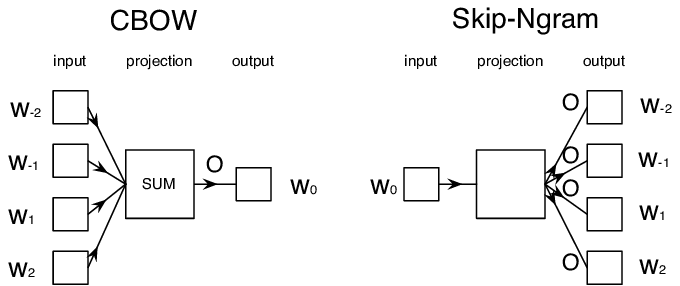

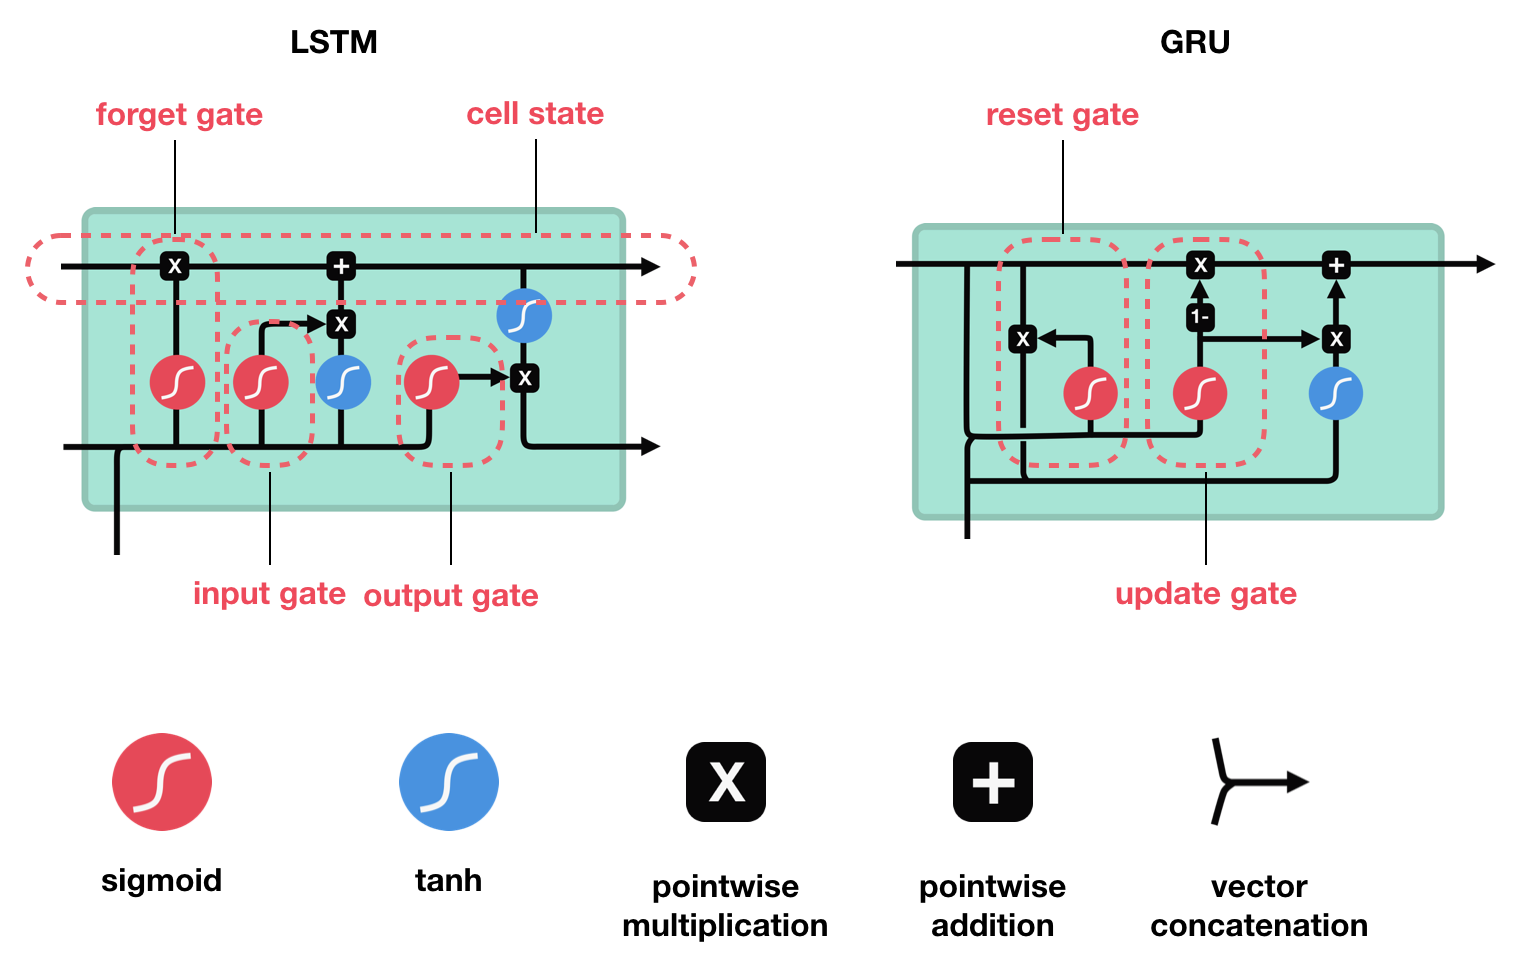

<img src=http://ufldl.stanford.edu/wiki/images/thumb/6/6c/Convolution_schematic.gif/300px-Convolution_schematic.gif>

<img src=https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif>

In [53]:
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical

In [54]:
from tensorflow import keras
from tensorflow.keras.layers import GRU, Embedding, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, BatchNormalization, Input

In [55]:
model = tf.keras.Sequential()
model.add(Embedding(input_dim=len(vocab)+1, output_dim=32))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
# model.add(GRU(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-26 15:12:11.679140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 15:12:11.679354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [56]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

/Users/yourlogarithm/.miniforge3/envs/ml/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [57]:
model_name = '3_test.h5'

callbacks = list()
callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0, mode='auto', patience=2))
callbacks.append(ModelCheckpoint(model_name, monitor='val_acc', save_weights_only=False, save_best_only=True, mode='max'))

In [58]:
model.fit(X_train, Y_train,
        epochs=100, 
        verbose=1,
        batch_size=64,
        validation_split=0.2,
        shuffle=False,
        callbacks=callbacks,)

Epoch 1/100


2022-05-26 15:12:11.949528: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-26 15:12:12.184623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 998/1000 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.6951

2022-05-26 15:12:26.597794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 15s 15ms/step - loss: 0.5671 - accuracy: 0.6952 - val_loss: 0.5248 - val_accuracy: 0.7364
Epoch 2/100
1000/1000 [==============================] - 14s 14ms/step - loss: 0.4966 - accuracy: 0.7538 - val_loss: 0.5271 - val_accuracy: 0.7336
Epoch 3/100
1000/1000 [==============================] - 14s 14ms/step - loss: 0.4462 - accuracy: 0.7872 - val_loss: 0.5586 - val_accuracy: 0.7261


2022-05-26 15:12:55.479771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot:>

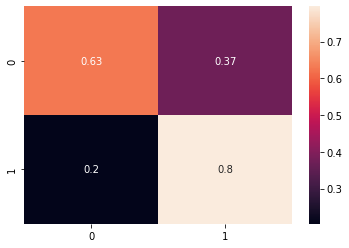

In [59]:
Y_pred = model.predict(X_test)
cmat = metrics.confusion_matrix(Y_test, Y_pred.round())
cmn = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True)